In [1]:
import sys
import pandas
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import gridspec
import corner
from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import MultipleLocator
from scipy.optimize import minimize
sys.path.append("../DependenceFitter-V2")

In [2]:
# from drw_toolkit.py import hampel_filter, drw_mle
from DependenceFitter import DependenceFitter1,DependenceFitter2
from DependenceFitter import median_and_error,get_computed_jpm, tau0_to_tau1
JPM, rho_iter = get_computed_jpm()

Computing JPM


# Fig1. JPM

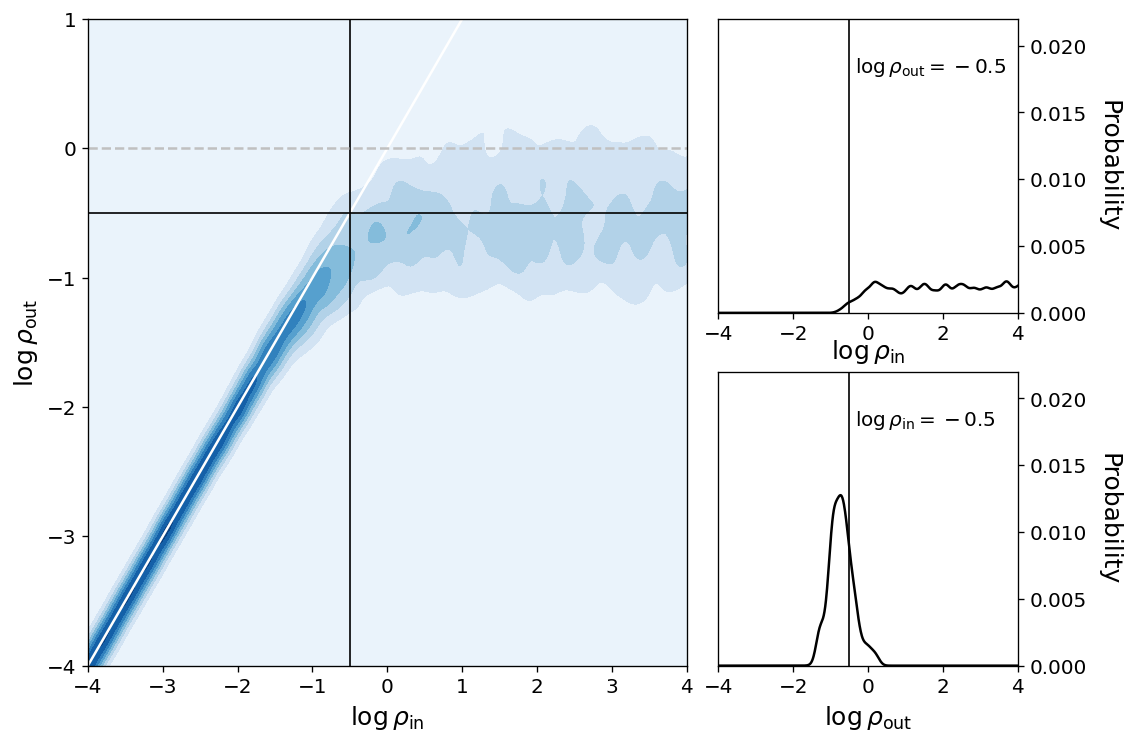

In [3]:
def softplus(x,s_k=1):
    return x - s_k * np.log(1 + np.exp(x / s_k))

H2 = JPM[-1]
fig = plt.figure(figsize=(10,7), dpi=120,facecolor='white')

gs = gridspec.GridSpec(2, 2, height_ratios=[0.5,0.5], width_ratios=[0.8,0.4])
gs.update(hspace=0.2)
gs.update(wspace=0.07)

ax0 = fig.add_subplot(gs[:,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[1,1])
ax0.contourf(rho_iter,rho_iter, H2,cmap='Blues')

ax0.set_xlim(-4,4)
ax0.set_ylim(-4,1)

ax0.plot(np.arange(-4,5),np.arange(-4,5),'w-')
# ax0.plot(np.arange(-4,5), softplus(np.arange(-4,5)+ 0.511636601229464, 0.4239987587065787)-0.4977552447495435, '--', color='navy')
ax0.axvline(-0.5, color='k', ls='-', lw=1)
ax0.axhline(-0.5, color='k', ls='-', lw=1)
ax0.axhline(0 , color='silver', ls='--')
ax0.set_ylabel(r"$\log \rho_{\rm out} $", fontsize=15)
ax0.set_xlabel(r"$\log \rho_{\rm in} $", fontsize=15)
ax0.tick_params(axis='both', labelsize=12)

ind = np.argmin(np.abs(rho_iter - np.log10(0.5)))
ax1.plot(rho_iter, H2[ind,:]/np.sum(H2[ind,:]), color='k')
ax1.axvline(-0.5, color='k',lw=1)
ax1.set_ylim(0,0.022)
ax1.set_xlim(-4,4)
ax1.set_xlabel(r"$\log \rho_{\rm in} $", fontsize=15,labelpad=5,va='center',ha='center')

ax1.set_ylabel(r"Probability",fontsize=15, rotation=-90,labelpad=20,va='bottom',ha='center')
ax1.yaxis.set_major_locator(MultipleLocator(0.005))
ax1.text(-0.35,0.018,r"$\log \rho_{\rm out} = -0.5 $",fontsize=12)
ax1.tick_params(axis='y', which='both',labelright=True, labelleft=False,right=True, left=False)
ax1.yaxis.set_label_position('right')
ax1.tick_params(axis='both', labelsize=12)

ax2.plot(rho_iter, H2[:,ind]/np.sum(H2[:,ind]), color='k')
ax2.set_ylim(0,0.022)
ax2.set_xlim(-4,4)
ax2.axvline(-0.5, color='k',lw=1)
ax2.set_xlabel(r"$\log \rho_{\rm out} $", fontsize=15)
ax2.set_ylabel(r"Probability",fontsize=15, rotation=-90,labelpad=20,va='bottom',ha='center')
ax2.yaxis.set_major_locator(MultipleLocator(0.005))
ax2.tick_params(axis='y', which='both',labelright=True, labelleft=False,right=True, left=False)
ax2.yaxis.set_label_position('right')
ax2.tick_params(axis='both', labelsize=12)
ax2.text(-0.35,0.018,r"$\log \rho_{\rm in} = -0.5 $",fontsize=12)
fig.savefig("fig1.png",bbox_inches="tight")

# Fig2. Illustration of A Toy Model

In [4]:
np.random.seed(4)
n_samples = 500
noise = 0.25
logMBH_array = np.random.uniform(5, 11, n_samples)
baseline = np.random.uniform(10,1e3,n_samples)
n_cadence = np.random.uniform(10,1e3,n_samples)

tau_in = np.random.normal(0.5*logMBH_array-1.7, noise)
tau_m, tau_std = tau0_to_tau1(tau_in, baseline, n_cadence)
tau =  np.random.normal(tau_m, tau_std)

choice = np.random.choice(np.where(10**tau < baseline )[0], size=100)
mask = 10**tau_m[choice] < 0.1 * baseline[choice]
np.polyfit(logMBH_array, tau_in,deg=1)

array([ 0.49631172, -1.66655077])

In [5]:
tau = tau[choice]
baseline = baseline[choice]
n_cadence = n_cadence[choice]
log_M_BH = logMBH_array[choice]
flat_samples = DependenceFitter1(tau, baseline,n_cadence, log_M_BH).fit()

100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [00:22<00:00, 44.13it/s]


[ 0.33222613 -0.798405  ]
[0.17342639 0.24223689]


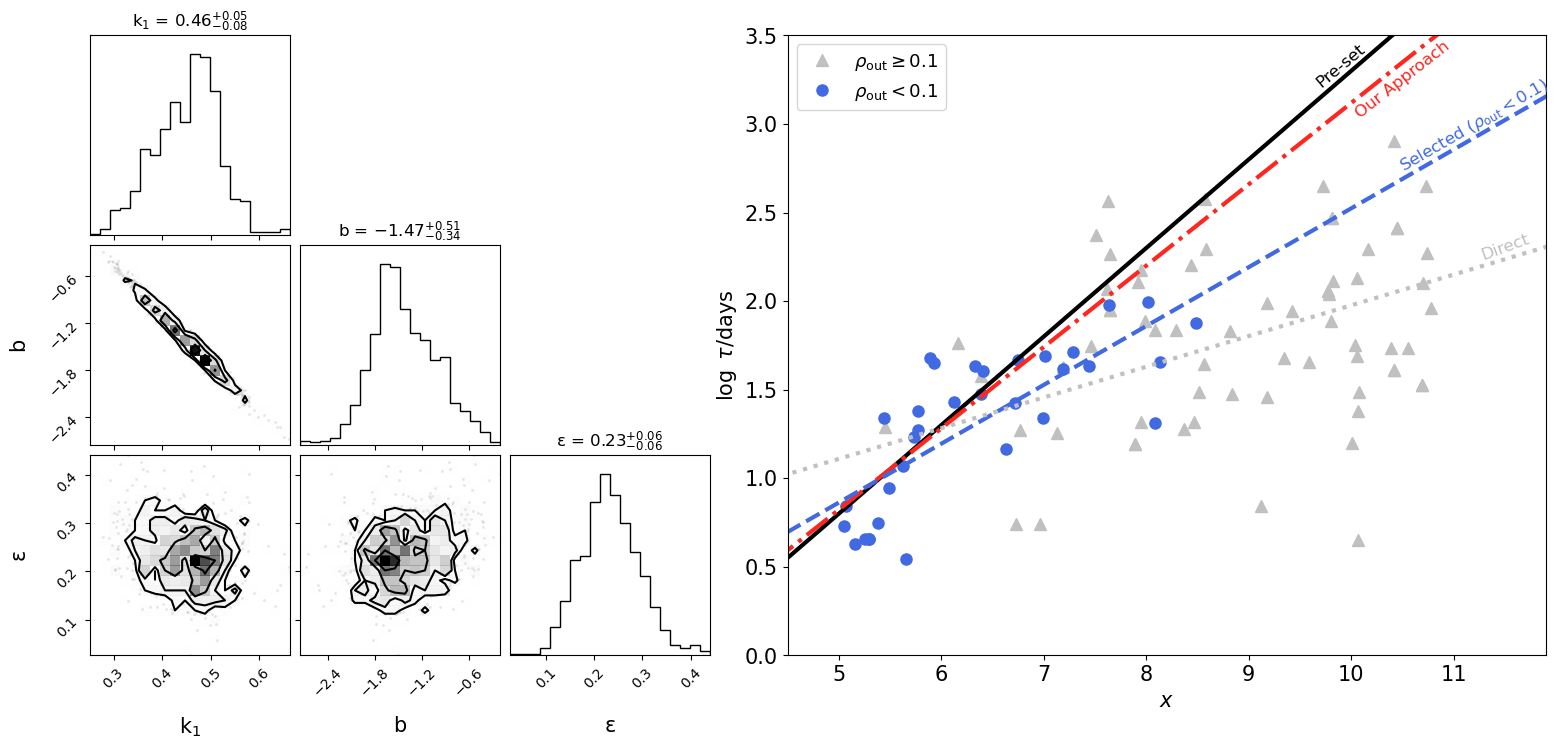

In [6]:
x_iter = np.arange(3,13)
fig_corner = corner.corner(
    flat_samples,show_titles=True,labels=[r"$\rm k_1$",r"$\rm b$",r"$\rm \epsilon$"],
    label_kwargs = dict(fontsize=15), title_kwargs=dict(fontsize=12),
    figsize=(8,6)
);
gs = gridspec.GridSpec(ncols=2, nrows=1, figure=fig_corner)
ax = fig_corner.add_subplot(gs[:, -1])
box = ax.get_position()
box.x0 = box.x0 + 0.5
box.x1 = box.x1 + 1.1
ax.set_position(box)

ax.plot(log_M_BH[~mask], tau[~mask], '^',markersize=8, c='silver', label=r"$\rho_{\rm out}\geq 0.1$")
ax.plot(log_M_BH[mask], tau[mask], 'o', markersize=8, c='royalblue', label=r"$\rho_{\rm out}< 0.1$")
ax.plot(x_iter, 0.5*x_iter-1.7, lw=3,color='k')
ax.text(9.9, 0.5*9.9-1.7+0.08, "Pre-set", rotation=40, ha='center', va='center', color='k', fontsize=12)
ax.plot(x_iter, np.poly1d([np.median(flat_samples[:,0]), np.median(flat_samples[:,1])])(x_iter), lw=3,ls='-.',color='#FF261F')
ax.text(10.5, np.poly1d([np.median(flat_samples[:,0]), np.median(flat_samples[:,1])])(10.5) - 0.1, "Our Approach", rotation=38, ha='center', va='center', color='#FF261F', fontsize=12)
ax.plot(x_iter, np.poly1d(np.polyfit(log_M_BH[mask], tau[mask], deg=1))(x_iter), lw=3,ls='--', color='royalblue')
ax.text(11.2, np.poly1d(np.polyfit(log_M_BH[mask], tau[mask], deg=1))(11.2) + 0.07, r"Selected ($\rho_{\rm out}< 0.1$)", rotation=30, ha='center', va='center', color='royalblue', fontsize=12)
print(np.polyfit(log_M_BH[mask], tau[mask], deg=1))

ax.plot(x_iter, np.poly1d(np.polyfit(log_M_BH, tau, deg=1))(x_iter), lw=3,ls=':', color='silver')
ax.text(11.5, np.poly1d(np.polyfit(log_M_BH, tau, deg=1))(11.5) + 0.07, "Direct", rotation=20, ha='center', va='center', color='silver', fontsize=12)
print(np.polyfit(log_M_BH, tau, deg=1))

ax.set_xlabel(r"$x$", fontsize=15)
ax.set_ylabel(r"$\log\ \tau/{\rm days}$", fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_xlim(4.5,11.9)
ax.set_ylim(0,3.5)
ax.legend(fontsize=13)
fig_corner.savefig("fig2.png",bbox_inches="tight")

# Import Samples

In [7]:
df_burke = pandas.read_pickle("df_burke.pkl")
df_ren = pandas.read_pickle("df_ren.pkl")
df_combined = pandas.concat([df_burke,df_ren], axis=0)
df_combined = df_combined.reset_index(drop=True)


mask_burke = (df_burke.Delta_AIC_low >1) & (df_burke.Delta_AIC_hi >1) & (df_burke.baseline/(df_burke.ncadence-1) < 10**df_burke.tau_mle)
mask_ren = (df_ren.Delta_AIC_low >1) & (df_ren.Delta_AIC_hi >1) & (df_ren.baseline/(df_ren.ncadence-1) < 10**df_ren.tau_mle)
mask_combined = (df_combined.Delta_AIC_low >1) & (df_combined.Delta_AIC_hi >1) & (df_combined.baseline/(df_combined.ncadence-1) < 10**df_combined.tau_mle)

# Fig3. Sample Properties

In [8]:
def stephist(ax, data, bins, color, ls='-', label=None, stroke=True, lw=1,alpha=0.2):
    # stroke=True
    counts, bin_edges = np.histogram(data, bins=bins) 
    if stroke:
        ax.hist(data, bins=bin_edges, histtype="step", color=color, ls=ls,lw=lw,linewidth=1.5, label=label)
        ax.fill_between(bin_edges[:-1], counts, step="post", color=color, alpha=alpha)
    else:
        ax.fill_between(bin_edges[:-1], counts, step="post", color=color, alpha=alpha, label=label)

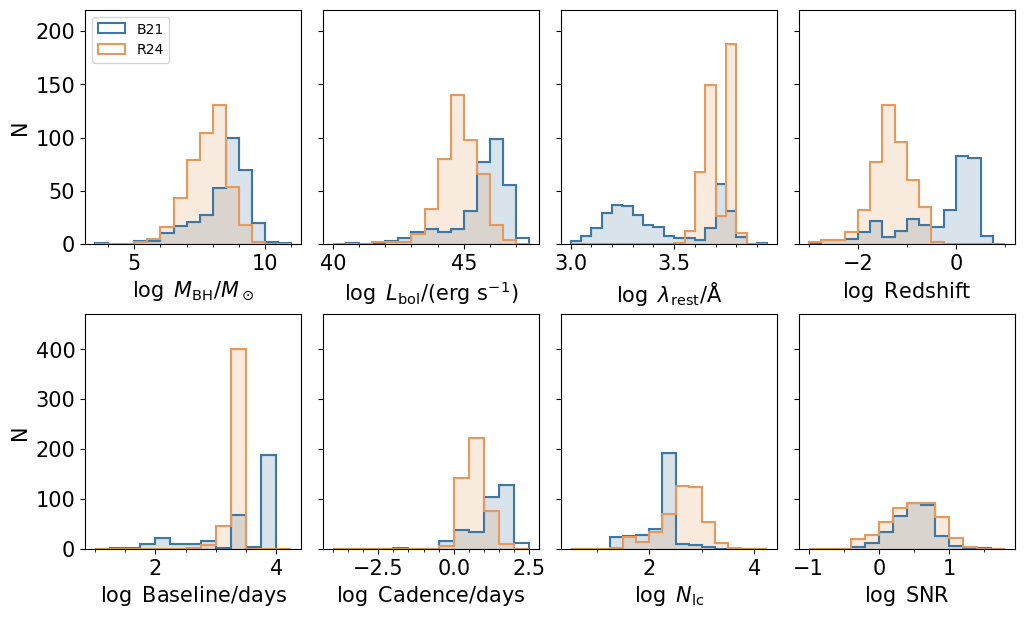

In [9]:

fig3_color1 = '#3F77A3'
fig3_color2 = '#E49A5C'
        
fig, axs = plt.subplots(2,4,figsize=(12,7))
ax = axs.flatten()[0]
bins = np.arange(3.5,11.5,0.5)
stephist(ax, df_burke[mask_burke].log_M_BH, bins, fig3_color1, '-', "B21")
stephist(ax, df_ren[mask_ren].log_M_BH, bins, fig3_color2, '-', "R24")
ax.set_xlabel(r"$\log\ M_{\rm BH}/M_\odot$", fontsize=15)
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax = axs.flatten()[1]
bins = np.arange(40,48,0.5)
stephist(ax, df_burke[mask_burke].log_L_bol, bins, fig3_color1, '-')
stephist(ax, df_ren[mask_ren].log_L_bol, bins, fig3_color2, '-')
ax.set_xlabel(r"$\log\ L_{\rm bol}/({\rm erg\ s^{-1}})$", fontsize=15)
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax = axs.flatten()[2]
bins =np.arange(3,4,0.05)
stephist(ax, df_burke[mask_burke].wl_rest, bins, fig3_color1, '-')
stephist(ax, df_ren[mask_ren].wl_rest, bins, fig3_color2, '-')
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.set_xlabel(r"$\log\ \lambda_{\rm rest}/{\rm \AA}$", fontsize=15)
ax = axs.flatten()[3]
bins = np.arange(-3,1.25,0.25)
stephist(ax, np.log10(df_burke[mask_burke].z), bins, fig3_color1, '-')
stephist(ax, np.log10(df_ren[mask_ren].z), bins, fig3_color2, '-')
ax.set_xlabel(r"$\log$ Redshift", fontsize=15)
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax = axs.flatten()[4]
bins = np.arange(1,4.5,0.25)
stephist(ax, np.log10(df_burke[mask_burke].baseline), bins, fig3_color1, '-')
stephist(ax, np.log10(df_ren[mask_ren].baseline), bins, fig3_color2, '-')
ax.set_xlabel(r"$\log$ Baseline/days", fontsize=15)
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax = axs.flatten()[5]
stephist(ax, np.log10(df_burke[mask_burke].baseline/(df_burke[mask_burke].ncadence-1)), np.arange(-4,3,0.5), fig3_color1, '-')
stephist(ax, np.log10(df_ren[mask_ren].baseline/(df_ren[mask_ren].ncadence-1)), np.arange(-4,3,0.5), fig3_color2, '-')
ax.set_xlabel(r"$\log$ Cadence/days", fontsize=15)
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax = axs.flatten()[6]
bins=np.arange(0.5,4.5,0.25)
stephist(ax, np.log10(df_burke[mask_burke].ncadence), bins, fig3_color1, '-')
stephist(ax, np.log10(df_ren[mask_ren].ncadence), bins, fig3_color2, '-')
ax.set_xlabel(r"$\log\ N_{\rm lc}$", fontsize=15)
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax = axs.flatten()[7]
bins= np.arange(-1,2,0.2)
stephist(ax, np.log10(df_burke[mask_burke].SNR_mle), bins, fig3_color1, '-')
stephist(ax, np.log10(df_ren[mask_ren].SNR_mle), bins, fig3_color2, '-')
ax.set_xlabel(r"$\log$ SNR", fontsize=15)
ax.xaxis.set_minor_locator(AutoMinorLocator(2))

for i in range(8):
    ax = axs.flatten()[i]
    ax.tick_params(axis='both', labelsize=15)
    if i%4 !=0:ax.set_yticklabels([])
    else:ax.set_ylabel(r"N", fontsize=15)
    if i<4: ax.set_ylim(0,220)
    else: ax.set_ylim(0,470)

axs.flatten()[0].legend(loc="upper left")
# fig.tight_layout()
plt.subplots_adjust(hspace=0.3) 
plt.subplots_adjust(wspace=0.1) 

fig.savefig("fig3.png",bbox_inches="tight")

# Fig4. Mock Test

In [10]:
Coefs_Sum = np.load("Coefs_Sum.npy", allow_pickle=True)
Coefs_Sum.shape

(54, 100)

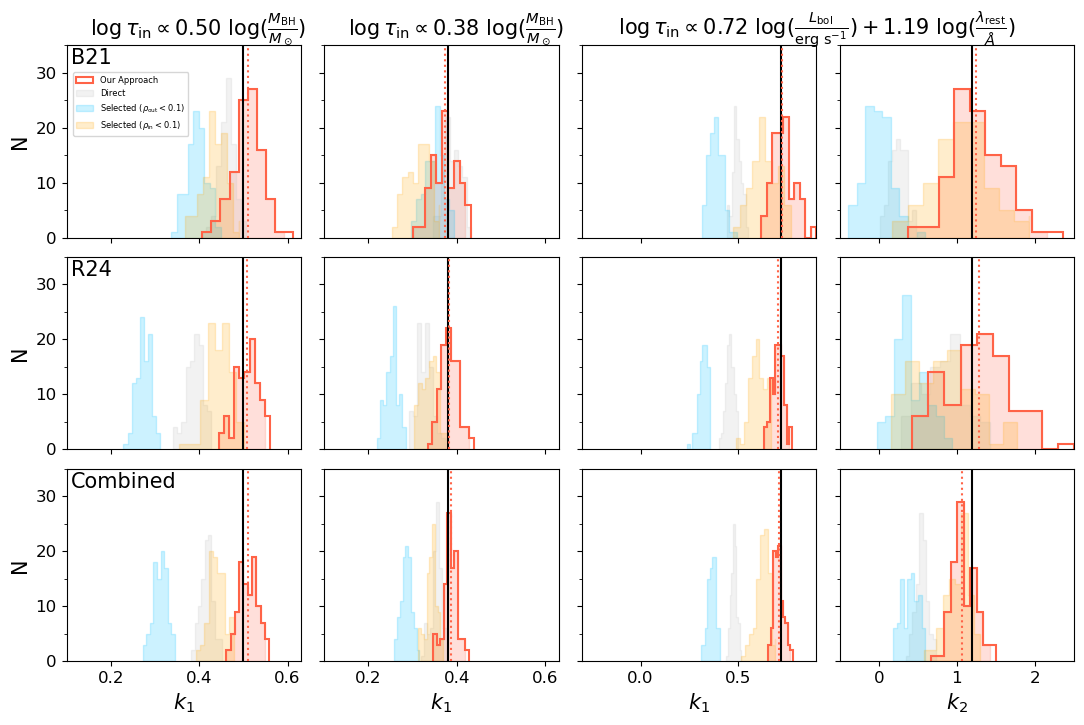

In [11]:
fig4_color1 = 'tomato'
fig4_color2 = 'silver'
fig4_color3 = 'deepskyblue'
fig4_color4 = 'orange'

fig, axs = plt.subplots(3,4, figsize=(13,8), facecolor='w')
ylim=35
for df_code in [0,1,2]:
    # for mask_code, color in zip([0,1,2,3,4], ['k','r','y','magenta','g']):
    # for mask_code, color in zip([0,1], ['tomato','#CCA4E3']):
    for mask_code, color in zip([0], [fig4_color1]):

        dependence_code = 0
        sum_code = dependence_code+(df_code)*3+(mask_code)*3*3
        stephist(axs[df_code,0], np.vstack(Coefs_Sum[sum_code])[:, 0], 10, color, ls='-', lw=3, label="Our Approach")
        axs[df_code,0].axvline(np.median(np.vstack(Coefs_Sum[sum_code])[:, 0]), color=color, ls=':',zorder=10)
        dependence_code = 1
        sum_code = dependence_code+(df_code)*3+(mask_code)*3*3
        stephist(axs[df_code,1], np.vstack(Coefs_Sum[sum_code])[:, 0], 10, color, ls='-', label=None)
        axs[df_code,1].axvline(np.median(np.vstack(Coefs_Sum[sum_code])[:, 0]), color=color, ls=':',zorder=10)
        
        dependence_code = 2
        sum_code = dependence_code+(df_code)*3+(mask_code)*3*3
        stephist(axs[df_code,2], np.vstack(Coefs_Sum[sum_code])[:, 0], 10, color, ls='-', label=None)
        stephist(axs[df_code,3], np.vstack(Coefs_Sum[sum_code])[:, 1], 10, color, ls='-', label=None)
        axs[df_code,2].axvline(np.median(np.vstack(Coefs_Sum[sum_code])[:, 0]), color=color, ls=':',zorder=10)
        axs[df_code,3].axvline(np.median(np.vstack(Coefs_Sum[sum_code])[:, 1]), color=color, ls=':',zorder=10)

         
    dependence_code = 0
    sum_code = dependence_code+(df_code)*3#+(mask_code)*3*3
    axs[df_code,0].set_ylim(0,ylim)

    stephist(axs[df_code,0], np.vstack(Coefs_Sum[sum_code])[:, 3], 10, fig4_color2, ls='-', label="Direct", stroke=False, alpha=0.2)
    stephist(axs[df_code,0], np.vstack(Coefs_Sum[sum_code])[:, 5], 10, fig4_color3, ls='-', label=r"Selected ($\rho_{\rm out}< 0.1$)", stroke=False, alpha=0.2)
    stephist(axs[df_code,0], np.vstack(Coefs_Sum[sum_code])[:, 7], 10, fig4_color4, ls='-', label=r"Selected ($\rho_{\rm in}< 0.1$)", stroke=False, alpha=0.2)
    axs[df_code,0].tick_params(axis='y', which='both',labelright=False, labelbottom=False)
    axs[df_code,0].yaxis.set_major_locator(MultipleLocator(10))
    axs[df_code,0].yaxis.set_minor_locator(AutoMinorLocator(2))
   
    dependence_code = 1
    sum_code = dependence_code+(df_code)*3#+(mask_code)*3*3
    axs[df_code,1].set_ylim(0,ylim)
    # ax = axs[df_code,1].twinx()
    stephist(axs[df_code,1], np.vstack(Coefs_Sum[sum_code])[:, 3], 10, fig4_color2, ls='-', label=None, stroke=False, alpha=0.2)
    stephist(axs[df_code,1], np.vstack(Coefs_Sum[sum_code])[:, 5], 10, fig4_color3, ls='-', label=None, stroke=False, alpha=0.2)
    stephist(axs[df_code,1], np.vstack(Coefs_Sum[sum_code])[:, 7], 10, fig4_color4, ls='-', label=None, stroke=False, alpha=0.2)
    axs[df_code,1].tick_params(axis='y', which='both',labelright=False, labelbottom=False)
    axs[df_code,1].yaxis.set_major_locator(MultipleLocator(10))
    axs[df_code,1].yaxis.set_minor_locator(AutoMinorLocator(2))

    dependence_code = 2
    sum_code = dependence_code+(df_code)*3#+(mask_code)*3*3
    axs[df_code,2].set_ylim(0,ylim)
    # ax = axs[df_code,2].twinx()
    stephist(axs[df_code,2], np.vstack(Coefs_Sum[sum_code])[:, 4], 10, fig4_color2, ls='-', label=None, stroke=False, alpha=0.2)
    stephist(axs[df_code,2], np.vstack(Coefs_Sum[sum_code])[:, 7], 10, fig4_color3, ls='-', label=None, stroke=False, alpha=0.2)
    stephist(axs[df_code,2], np.vstack(Coefs_Sum[sum_code])[:, 10], 10, fig4_color4, ls='-', label=None, stroke=False, alpha=0.2)
    axs[df_code,2].tick_params(axis='y', which='both',labelright=False, labelbottom=False)
    axs[df_code,2].yaxis.set_major_locator(MultipleLocator(10))
    axs[df_code,2].yaxis.set_minor_locator(AutoMinorLocator(2))
    axs[df_code,3].set_ylim(0,ylim)
    # ax = axs[df_code,3].twinx()
    stephist(axs[df_code,3], np.vstack(Coefs_Sum[sum_code])[:, 5], 10, fig4_color2, ls='-', label=None, stroke=False, alpha=0.2)
    stephist(axs[df_code,3], np.vstack(Coefs_Sum[sum_code])[:, 8], 10, fig4_color3, ls='-', label=None, stroke=False, alpha=0.2)
    stephist(axs[df_code,3], np.vstack(Coefs_Sum[sum_code])[:, 11], 10, fig4_color4, ls='-', label=None, stroke=False, alpha=0.2)
    axs[df_code,3].yaxis.set_major_locator(MultipleLocator(10))
    axs[df_code,3].yaxis.set_minor_locator(AutoMinorLocator(2))
    
    axs[df_code,0].axvline(0.5, c='k',  ls='-')
    axs[df_code,1].axvline(0.38, c='k', ls= '-')
    axs[df_code,2].axvline(0.72, c='k',  ls='-')
    axs[df_code,3].axvline(1.19, c='k',  ls='-')

    axs[df_code,0].set_xlim(0.1,0.63)
    axs[df_code,1].set_xlim(0.1,0.63)
    axs[df_code,2].set_xlim(-0.3,0.9)
    axs[df_code,3].set_xlim(-0.5,2.5)
    
axs[2,0].set_xlabel(r"$k_1$", fontsize=15)
axs[2,1].set_xlabel(r"$k_1$", fontsize=15)
axs[2,2].set_xlabel(r"$k_1$", fontsize=15)
axs[2,3].set_xlabel(r"$k_2$", fontsize=15)

for i in range(len(axs.flatten())):
    ax = axs.flatten()[i]
    ax.tick_params(axis='both', labelsize=12)
    ax.yaxis.set_major_locator(MultipleLocator(10))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))

    if i%4 !=0:
        ax.tick_params(axis='y', which='both',labelleft=False, labelbottom=False)
    else: ax.set_ylabel("N", fontsize=15)

    if i <8: 
        ax.tick_params(axis='x', which='both',labelleft=False, labelbottom=False)
    # ax.text(-2.7,4.7,f"N={n_cadence}", fontsize=12)
plt.subplots_adjust(hspace=0.1)
plt.subplots_adjust(wspace=0.1)
for i, text in zip(range(3), ["B21", "R24","Combined"]):
    ax = axs[i,0]
    ax.text(ax.get_xlim()[0]+0.01, 0.9*ax.get_ylim()[1], text, fontsize=15, zorder=5)
for i, text in zip(range(3), [r"$\log \tau_{\rm in} \propto 0.50\ \log (\frac{M_{\rm BH}}{M_\odot})$", r"$\log \tau_{\rm in} \propto 0.38\ \log (\frac{M_{\rm BH}}{M_\odot})$",r"  $ \log \tau_{\rm in} \propto 0.72\ \log (\frac{L_{\rm bol}}{{\rm erg\ s^{-1}}}) + 1.19\ \log(\frac{\lambda_{\rm rest}}{\AA}) $"]):
    ax = axs[0,i]
    ax.text(np.percentile(ax.get_xlim(),10), 1.05*ax.get_ylim()[1], text, fontsize=15)
axs[0,0].legend(loc="upper left",bbox_to_anchor=(0.01, 0.88), fontsize=6)
fig.savefig("fig4.png",bbox_inches="tight")

# Tab1. Implement

In [12]:
flat_samples_array = []
for df in [df_burke, df_ren, df_combined]:
    mask_df = (df.Delta_AIC_low>1) & (df.Delta_AIC_hi>1) & (df.baseline/(df.ncadence-1) < 10**df.tau_mle)
    df = df[mask_df]
    Fitter = DependenceFitter1(df.tau_mle.to_numpy(), df.baseline.to_numpy(), df.ncadence.to_numpy(), df.log_M_BH.to_numpy(), df.log_M_BH_e.to_numpy(), redshift=df.z.to_numpy())
    flat_samples = Fitter.fit()
    flat_samples_array.append(flat_samples)
    Fitter = DependenceFitter2(df.tau_mle.to_numpy(), df.baseline.to_numpy(),  df.ncadence.to_numpy(), df.log_L_bol.to_numpy(), df.wl_rest.to_numpy(), df.log_L_bol_e.to_numpy(),redshift=df.z.to_numpy())
    flat_samples = Fitter.fit()
    flat_samples_array.append(flat_samples)
flat_samples_burke1,flat_samples_burke2,flat_samples_ren1,flat_samples_ren2,flat_samples_combined1,flat_samples_combined2 = flat_samples_array

print(r"Burke+21   &&$ %.2f ^{+%.2f}_{-%.2f}$ &&$ %.2f ^{+%.2f}_{-%.2f}$&$ %.2f ^{+%.2f}_{-%.2f}$\\"%(*median_and_error(flat_samples_burke1,0),*median_and_error(flat_samples_burke1,1),*median_and_error(flat_samples_burke1,2)))
print(r"Ren+24     &&$ %.2f ^{+%.2f}_{-%.2f}$ &&$ %.2f ^{+%.2f}_{-%.2f}$&$ %.2f ^{+%.2f}_{-%.2f}$\\"%(*median_and_error(flat_samples_ren1,0),*median_and_error(flat_samples_ren1,1),*median_and_error(flat_samples_ren1,2)))
print(r"Combined  &&$ %.2f ^{+%.2f}_{-%.2f}$ &&$ %.2f ^{+%.2f}_{-%.2f}$&$ %.2f ^{+%.2f}_{-%.2f}$\\"%(*median_and_error(flat_samples_combined1,0),*median_and_error(flat_samples_combined1,1),*median_and_error(flat_samples_combined1,2)))
print(r"")
print(r"Burke+21   &&$ %.2f ^{+%.2f}_{-%.2f}$ &$ %.2f ^{+%.2f}_{-%.2f}$&$ %.2f ^{+%.2f}_{-%.2f}$&$ %.2f ^{+%.2f}_{-%.2f}$\\"%(*median_and_error(flat_samples_burke2,0),*median_and_error(flat_samples_burke2,1),*median_and_error(flat_samples_burke2,2),*median_and_error(flat_samples_burke2,3)))
print(r"Ren+24    &&$ %.2f ^{+%.2f}_{-%.2f}$ &$ %.2f ^{+%.2f}_{-%.2f}$&$ %.2f ^{+%.2f}_{-%.2f}$&$ %.2f ^{+%.2f}_{-%.2f}$\\"%(*median_and_error(flat_samples_ren2,0),*median_and_error(flat_samples_ren2,1),*median_and_error(flat_samples_ren2,2),*median_and_error(flat_samples_ren2,3)))
print(r"Combined   &&$ %.2f ^{+%.2f}_{-%.2f}$ &$ %.2f ^{+%.2f}_{-%.2f}$&$ %.2f ^{+%.2f}_{-%.2f}$&$ %.2f ^{+%.2f}_{-%.2f}$\\"%(*median_and_error(flat_samples_combined2,0),*median_and_error(flat_samples_combined2,1),*median_and_error(flat_samples_combined2,2),*median_and_error(flat_samples_combined2,3)))


100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [01:50<00:00,  9.02it/s]

Burke+21   &&$ 0.53 ^{+0.05}_{-0.04}$ &&$ -1.70 ^{+0.30}_{-0.36}$&$ 0.22 ^{+0.06}_{-0.07}$\\
Ren+24     &&$ 0.45 ^{+0.04}_{-0.04}$ &&$ -1.17 ^{+0.35}_{-0.32}$&$ 0.58 ^{+0.03}_{-0.03}$\\
Combined  &&$ 0.51 ^{+0.03}_{-0.03}$ &&$ -1.60 ^{+0.22}_{-0.23}$&$ 0.52 ^{+0.03}_{-0.02}$\\

Burke+21   &&$ 0.58 ^{+0.07}_{-0.07}$ &$ 0.54 ^{+0.47}_{-0.39}$&$ -25.11 ^{+3.73}_{-5.20}$&$ 0.28 ^{+0.06}_{-0.06}$\\
Ren+24    &&$ 0.58 ^{+0.05}_{-0.05}$ &$ -0.32 ^{+0.46}_{-0.41}$&$ -22.70 ^{+3.08}_{-3.00}$&$ 0.52 ^{+0.03}_{-0.03}$\\
Combined   &&$ 0.58 ^{+0.04}_{-0.04}$ &$ 0.10 ^{+0.21}_{-0.25}$&$ -24.11 ^{+2.24}_{-2.32}$&$ 0.48 ^{+0.02}_{-0.02}$\\


In [13]:
flat_samples_array = []
for df in [df_burke, df_ren, df_combined]:
    mask_df = (df.Delta_AIC_low>1) & (df.Delta_AIC_hi>1) & (df.baseline/(df.ncadence-1) < 10**df.tau_mle) & (df.SNR_mle>1)
    df = df[mask_df]
    Fitter = DependenceFitter1(df.tau_mle.to_numpy(), df.baseline.to_numpy(), df.ncadence.to_numpy(), df.log_M_BH.to_numpy(), df.log_M_BH_e.to_numpy(), redshift=df.z.to_numpy())
    flat_samples = Fitter.fit()
    flat_samples_array.append(flat_samples)
    Fitter = DependenceFitter2(df.tau_mle.to_numpy(), df.baseline.to_numpy(),  df.ncadence.to_numpy(), df.log_L_bol.to_numpy(), df.wl_rest.to_numpy(), df.log_L_bol_e.to_numpy(),redshift=df.z.to_numpy())
    flat_samples = Fitter.fit()
    flat_samples_array.append(flat_samples)
flat_samples_burke1,flat_samples_burke2,flat_samples_ren1,flat_samples_ren2,flat_samples_combined1,flat_samples_combined2 = flat_samples_array

print(r"Burke+21   &&$ %.2f ^{+%.2f}_{-%.2f}$ &&$ %.2f ^{+%.2f}_{-%.2f}$&$ %.2f ^{+%.2f}_{-%.2f}$\\"%(*median_and_error(flat_samples_burke1,0),*median_and_error(flat_samples_burke1,1),*median_and_error(flat_samples_burke1,2)))
print(r"Ren+24     &&$ %.2f ^{+%.2f}_{-%.2f}$ &&$ %.2f ^{+%.2f}_{-%.2f}$&$ %.2f ^{+%.2f}_{-%.2f}$\\"%(*median_and_error(flat_samples_ren1,0),*median_and_error(flat_samples_ren1,1),*median_and_error(flat_samples_ren1,2)))
print(r"Combined  &&$ %.2f ^{+%.2f}_{-%.2f}$ &&$ %.2f ^{+%.2f}_{-%.2f}$&$ %.2f ^{+%.2f}_{-%.2f}$\\"%(*median_and_error(flat_samples_combined1,0),*median_and_error(flat_samples_combined1,1),*median_and_error(flat_samples_combined1,2)))
print(r"")
print(r"Burke+21   &&$ %.2f ^{+%.2f}_{-%.2f}$ &$ %.2f ^{+%.2f}_{-%.2f}$&$ %.2f ^{+%.2f}_{-%.2f}$&$ %.2f ^{+%.2f}_{-%.2f}$\\"%(*median_and_error(flat_samples_burke2,0),*median_and_error(flat_samples_burke2,1),*median_and_error(flat_samples_burke2,2),*median_and_error(flat_samples_burke2,3)))
print(r"Ren+24    &&$ %.2f ^{+%.2f}_{-%.2f}$ &$ %.2f ^{+%.2f}_{-%.2f}$&$ %.2f ^{+%.2f}_{-%.2f}$&$ %.2f ^{+%.2f}_{-%.2f}$\\"%(*median_and_error(flat_samples_ren2,0),*median_and_error(flat_samples_ren2,1),*median_and_error(flat_samples_ren2,2),*median_and_error(flat_samples_ren2,3)))
print(r"Combined   &&$ %.2f ^{+%.2f}_{-%.2f}$ &$ %.2f ^{+%.2f}_{-%.2f}$&$ %.2f ^{+%.2f}_{-%.2f}$&$ %.2f ^{+%.2f}_{-%.2f}$\\"%(*median_and_error(flat_samples_combined2,0),*median_and_error(flat_samples_combined2,1),*median_and_error(flat_samples_combined2,2),*median_and_error(flat_samples_combined2,3)))


100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [01:24<00:00, 11.83it/s]


Burke+21   &&$ 0.53 ^{+0.05}_{-0.04}$ &&$ -1.72 ^{+0.33}_{-0.37}$&$ 0.21 ^{+0.06}_{-0.07}$\\
Ren+24     &&$ 0.52 ^{+0.06}_{-0.05}$ &&$ -1.63 ^{+0.38}_{-0.41}$&$ 0.56 ^{+0.04}_{-0.03}$\\
Combined  &&$ 0.54 ^{+0.04}_{-0.04}$ &&$ -1.80 ^{+0.30}_{-0.33}$&$ 0.50 ^{+0.03}_{-0.03}$\\

Burke+21   &&$ 0.61 ^{+0.08}_{-0.07}$ &$ 0.77 ^{+0.45}_{-0.44}$&$ -27.67 ^{+4.84}_{-4.83}$&$ 0.27 ^{+0.06}_{-0.06}$\\
Ren+24    &&$ 0.65 ^{+0.04}_{-0.05}$ &$ -0.33 ^{+0.49}_{-0.52}$&$ -25.49 ^{+3.05}_{-2.77}$&$ 0.47 ^{+0.03}_{-0.03}$\\
Combined   &&$ 0.63 ^{+0.03}_{-0.04}$ &$ 0.34 ^{+0.19}_{-0.18}$&$ -26.89 ^{+2.12}_{-1.90}$&$ 0.45 ^{+0.02}_{-0.03}$\\


# Simulations for JPM
Our approach strongly relies on the joint probability distribution map to obtain the conditional probability distribution.

We repeat the simulations with different numbers of data points, uniformly choosing 10 values from 10 to 10000 on a logarithm scale, and here we show 6 out of the simulations.

Additionally, we select simulations where $\log (\sigma_{\rm out}/0.07) < 0.1$ (corresponding to an SNR of 0.7, with approximately $95\%$ light curves in the samples exceeding this value). 

The resulting maps are shown as follows. 

Except for the lower data density in this case due to the smaller range of selection, the shapes of the distribution remain largely unchanged, ensuring that our approach can be well applied to both the mock and real light curves in this study.

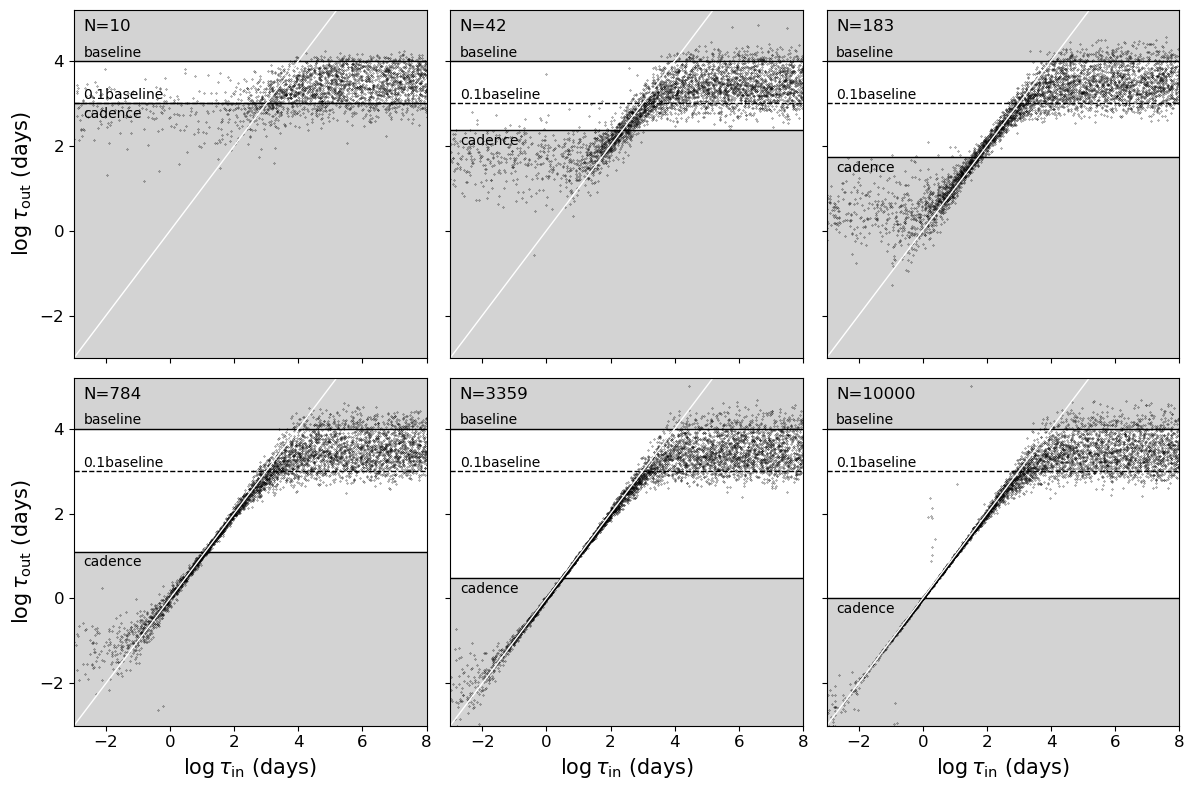

In [14]:
N1 = 1201
N2 = 101
base=1e4
fig, axs = plt.subplots(2,3,figsize=(12,8), facecolor='w')
for i, n_cadence in zip(range(6), [10, 42, 183, 784, 3359, 10000]):
    ax = axs.flatten()[i]
    params = np.load(f"../DependenceFitter-V2/simulate_mle_nc{n_cadence}.npy")
    log_tau_drw_true = np.linspace(-3, 9, N1)
    ind_array = (np.abs( np.log10(params[:, 1]) - np.log10(0.3) ) < 0.1)
    Delta_AIC_low = params[ind_array, 2]
    Delta_AIC_hi = params[ind_array, 3]
    tau1 =  params[ind_array, 0][(Delta_AIC_hi>1)&(Delta_AIC_low>1)]
    tau0 =  np.repeat(np.linspace(-3, 9, N1), N2)[ind_array][(Delta_AIC_hi>1)&(Delta_AIC_low>1)]
    ax.plot(tau0, tau1,'.', ms=0.5, c='k')
    ax.yaxis.set_major_locator(MultipleLocator(2))
    ax.axhline(np.log10(base/n_cadence), color='k', lw=1)
    ax.text(-2.7, np.log10(base/n_cadence)-0.35, "cadence", color='k')
    ax.axhline(np.log10(base), color='k', lw=1)
    ax.text(-2.7, np.log10(base)+0.1, "baseline", color='k')
    ax.axhline(np.log10(0.1*base), color='k',ls='--', lw=1)
    ax.text(-2.7, np.log10(base)-1+0.1, "0.1baseline", color='k')
    ax.set_xlim(-3, 8)
    ax.set_ylim(-3, 5.2)
    ax.fill_between(np.arange(ax.get_xlim()[0],ax.get_xlim()[1]+1), ax.get_ylim()[0],  np.log10(base/n_cadence), color='lightgrey')
    ax.fill_between(np.arange(ax.get_xlim()[0],ax.get_xlim()[1]+1), np.log10(base), ax.get_ylim()[1], color='lightgrey')
    ax.tick_params(axis='both', labelsize=12)
    if i%3 !=0:
        ax.tick_params(axis='y', which='both',labelleft=False, labelbottom=False)
    else: ax.set_ylabel(r"$\log \tau_{\rm out}\ ({\rm days}) $", fontsize=15)
    if i <3: 
        ax.tick_params(axis='x', which='both',labelleft=False, labelbottom=False)
    else: ax.set_xlabel(r"$\log \tau_{\rm in}\ ({\rm days}) $", fontsize=15)
    ax.text(-2.7,4.7,f"N={n_cadence}", fontsize=12)
    ax.plot(np.arange(-5,9), np.arange(-5,9), 'w', lw=1)
fig.tight_layout()
fig.savefig("figA1.png")

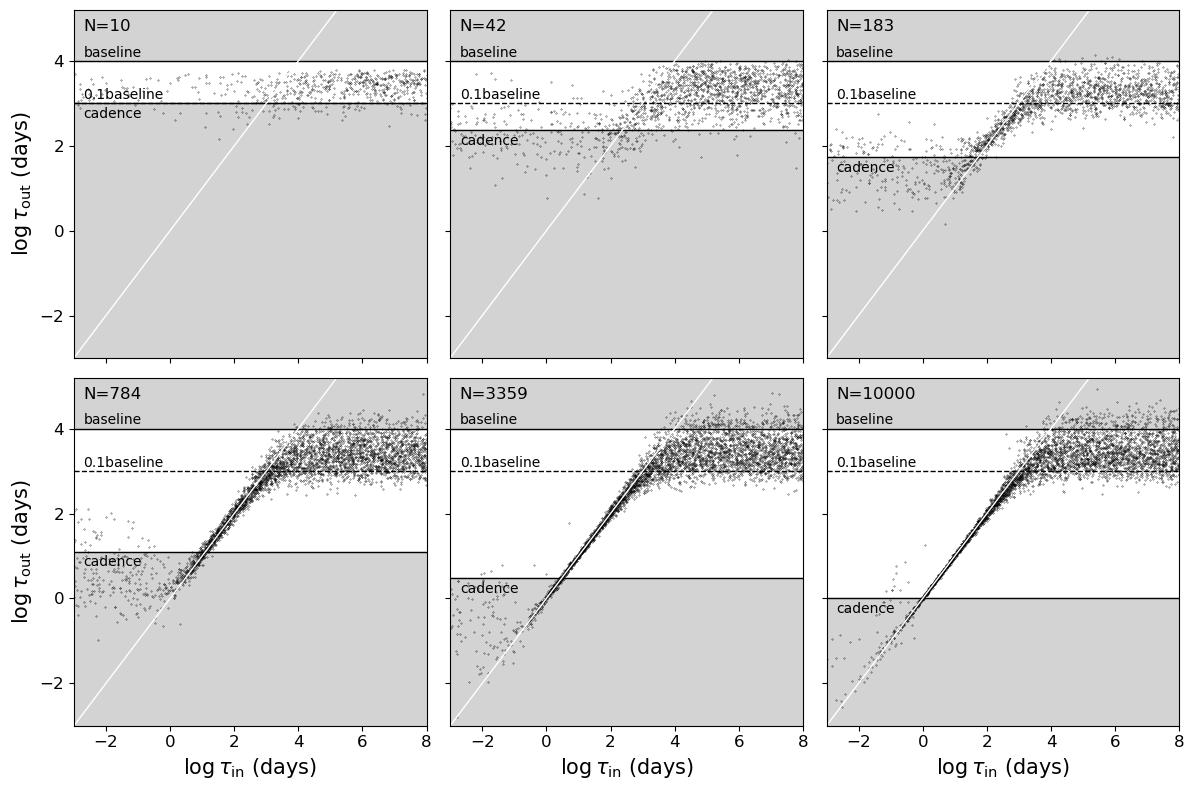

In [15]:
N1 = 1201
N2 = 101
base=1e4
fig, axs = plt.subplots(2,3,figsize=(12,8), facecolor='w')
for i, n_cadence in zip(range(6), [10, 42, 183, 784, 3359, 10000]):
    ax = axs.flatten()[i]
    params = np.load(f"../DependenceFitter-V2/simulate_mle_nc{n_cadence}.npy")
    log_tau_drw_true = np.linspace(-3, 9, N1)
    ind_array = (np.abs( np.log10(params[:, 1]) - np.log10(0.07) ) < 0.1)
    Delta_AIC_low = params[ind_array, 2]
    Delta_AIC_hi = params[ind_array, 3]
    tau1 =  params[ind_array, 0][(Delta_AIC_hi>1)&(Delta_AIC_low>1)]
    tau0 =  np.repeat(np.linspace(-3, 9, N1), N2)[ind_array][(Delta_AIC_hi>1)&(Delta_AIC_low>1)]
    ax.plot(tau0, tau1,'.', ms=0.5, c='k')
    ax.yaxis.set_major_locator(MultipleLocator(2))
    ax.axhline(np.log10(base/n_cadence), color='k', lw=1)
    ax.text(-2.7, np.log10(base/n_cadence)-0.35, "cadence", color='k')
    ax.axhline(np.log10(base), color='k', lw=1)
    ax.text(-2.7, np.log10(base)+0.1, "baseline", color='k')
    ax.axhline(np.log10(0.1*base), color='k',ls='--', lw=1)
    ax.text(-2.7, np.log10(base)-1+0.1, "0.1baseline", color='k')
    ax.set_xlim(-3, 8)
    ax.set_ylim(-3, 5.2)
    ax.fill_between(np.arange(ax.get_xlim()[0],ax.get_xlim()[1]+1), ax.get_ylim()[0],  np.log10(base/n_cadence), color='lightgrey')
    ax.fill_between(np.arange(ax.get_xlim()[0],ax.get_xlim()[1]+1), np.log10(base), ax.get_ylim()[1], color='lightgrey')
    ax.tick_params(axis='both', labelsize=12)
    if i%3 !=0:
        ax.tick_params(axis='y', which='both',labelleft=False, labelbottom=False)
    else: ax.set_ylabel(r"$\log \tau_{\rm out}\ ({\rm days}) $", fontsize=15)
    if i <3: 
        ax.tick_params(axis='x', which='both',labelleft=False, labelbottom=False)
    else: ax.set_xlabel(r"$\log \tau_{\rm in}\ ({\rm days}) $", fontsize=15)
    ax.text(-2.7,4.7,f"N={n_cadence}", fontsize=12)
    ax.plot(np.arange(-5,9), np.arange(-5,9), 'w', lw=1)
fig.tight_layout()
fig.savefig("figA2.png")

(-0.51163671756072, 0.4239995343141036, -0.49775517762815336)

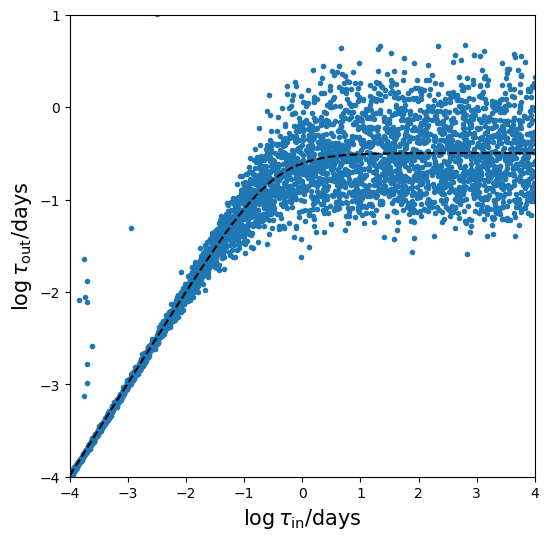

In [16]:
def softplus_adjusted(x, k_s=1):
    return x - k_s * np.log(1 + np.exp(x / k_s))
def softplus_adjusted_derivative(x, k_s=1):
    return 1 - 1 / (1 + np.exp(-x / k_s))
    
def log_likelihood(theta, x, y):
    point, k_s, intercept = theta
    model = softplus_adjusted(x-point, k_s) +intercept
    return -0.5 * np.sum((y - model) ** 2)
    
def local_average_using_hist(x, y, bins=10):
    hist, bin_edges = np.histogram(x, bins=bins) 
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  
    y_avg = np.zeros(bins)
    for i in range(bins):
        in_bin = (x >= bin_edges[i]) & (x < bin_edges[i + 1])
        if np.any(in_bin):  # 如果该区间内有数据
            y_avg[i] = np.mean(y[in_bin])
        else:
            y_avg[i] = np.nan 
    return y_avg, bin_centers
N1 = 1201
N2 = 101
params = np.load(f"../DependenceFitter-V2/simulate_mle_nc10000.npy")
log_tau_drw_true = np.linspace(-3, 9, N1)
ind_array = (np.abs( np.log10(params[:, 1]) - np.log10(0.3) ) < 0.1)
Delta_AIC_low = params[ind_array, 2]
Delta_AIC_hi = params[ind_array, 3]
tau1 =  params[ind_array, 0][(Delta_AIC_hi>1)&(Delta_AIC_low>1)]
tau0 =  np.repeat(np.linspace(-3, 9, N1), N2)[ind_array][(Delta_AIC_hi>1)&(Delta_AIC_low>1)]
tau1_bin, tau0_bin = local_average_using_hist(tau0, tau1, bins=100)

nll = lambda *args: -log_likelihood(*args)    
initial = np.array([-1, 10, 2]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(tau0_bin[:-10]-4, tau1_bin[:-10]-4))
point, k_s,intercept = soln.x

fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.plot(tau0-4,tau1-4,'.')
ax.plot(np.arange(-4,5,0.1) , softplus_adjusted(np.arange(-4,5,0.1)-point, k_s) + intercept, ls='--', color='k')
ax.set_ylabel(r"$\log \tau_{\rm out}/{\rm days} $", fontsize=15)
ax.set_xlabel(r"$\log \tau_{\rm in}/{\rm days}$", fontsize=15)
ax.set_xlim(-4,4)
ax.set_ylim(-4,1)
# plt.plot(np.arange(-4,5,0.1), softplus_adjusted_derivative(np.arange(-4,5,0.1)-point, 10))
point, k_s, intercept


# Selecting with SNR?
a comparison between the results from our approach, with and without the selection of SNR$>1$. 
No significant deviation is observed.

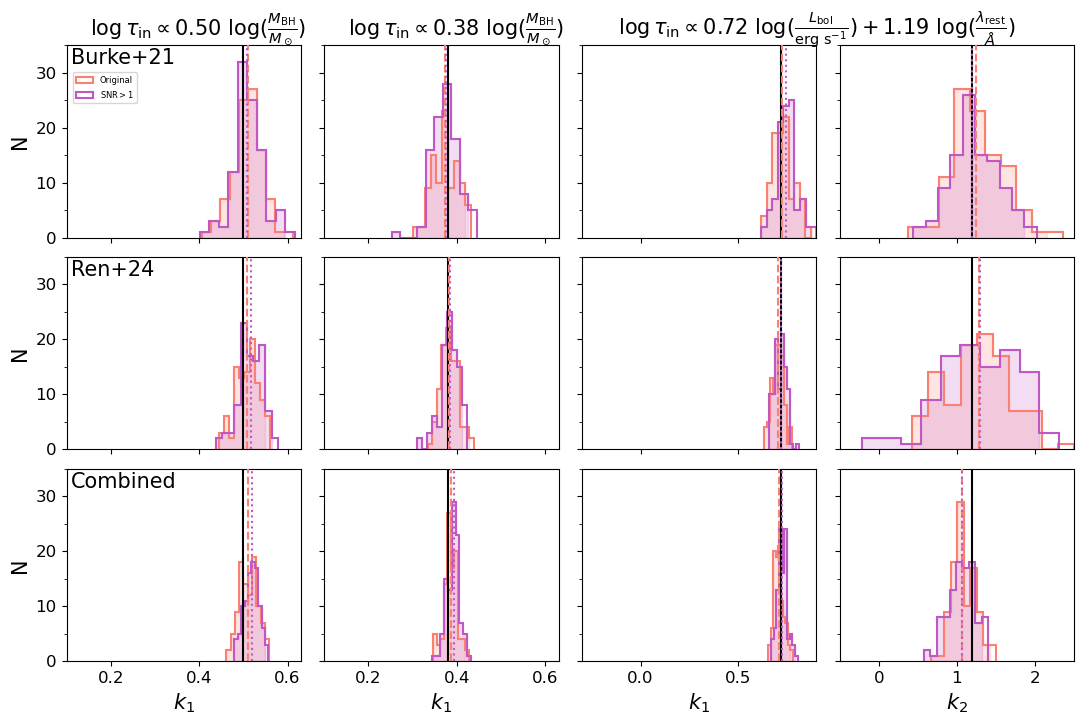

In [17]:
figC_color1 = 'salmon'
figC_color2 = '#BF57C5'

fig, axs = plt.subplots(3,4, figsize=(13,8), facecolor='w')
ylim=35
for df_code in [0,1,2]:
    for mask_code, color,ls,label in zip([0,4], [figC_color1,figC_color2], ['--',':'], ["Original", r"SNR$>$1"]):

        dependence_code = 0
        sum_code = dependence_code+(df_code)*3+(mask_code)*3*3
        stephist(axs[df_code,0], np.vstack(Coefs_Sum[sum_code])[:, 0], 10, color, ls='-', label=label)
        axs[df_code,0].axvline(np.median(np.vstack(Coefs_Sum[sum_code])[:, 0]), color=color, ls=ls,zorder=10)
        dependence_code = 1
        sum_code = dependence_code+(df_code)*3+(mask_code)*3*3
        stephist(axs[df_code,1], np.vstack(Coefs_Sum[sum_code])[:, 0], 10, color, ls='-', label=None)
        axs[df_code,1].axvline(np.median(np.vstack(Coefs_Sum[sum_code])[:, 0]), color=color, ls=ls,zorder=10)
        
        dependence_code = 2
        sum_code = dependence_code+(df_code)*3+(mask_code)*3*3
        stephist(axs[df_code,2], np.vstack(Coefs_Sum[sum_code])[:, 0], 10, color, ls='-', label=None)
        stephist(axs[df_code,3], np.vstack(Coefs_Sum[sum_code])[:, 1], 10, color, ls='-', label=None)
        axs[df_code,2].axvline(np.median(np.vstack(Coefs_Sum[sum_code])[:, 0]), color=color, ls=ls,zorder=10)
        axs[df_code,3].axvline(np.median(np.vstack(Coefs_Sum[sum_code])[:, 1]), color=color, ls=ls,zorder=10)

    
    axs[df_code,0].axvline(0.5, c='k',  ls='-')
    axs[df_code,1].axvline(0.38, c='k', ls= '-')
    axs[df_code,2].axvline(0.72, c='k',  ls='-')
    axs[df_code,3].axvline(1.19, c='k',  ls='-')

    axs[df_code,0].set_xlim(0.1,0.63)
    axs[df_code,1].set_xlim(0.1,0.63)
    axs[df_code,2].set_xlim(-0.3,0.9)
    axs[df_code,3].set_xlim(-0.5,2.5)
    
axs[2,0].set_xlabel(r"$k_1$", fontsize=15)
axs[2,1].set_xlabel(r"$k_1$", fontsize=15)
axs[2,2].set_xlabel(r"$k_1$", fontsize=15)
axs[2,3].set_xlabel(r"$k_2$", fontsize=15)

for i in range(len(axs.flatten())):
    ax = axs.flatten()[i]
    ax.tick_params(axis='both', labelsize=12)
    ax.yaxis.set_major_locator(MultipleLocator(10))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.set_ylim(0,ylim)
    if i%4 !=0:
        ax.tick_params(axis='y', which='both',labelleft=False, labelbottom=False)
    else: ax.set_ylabel("N", fontsize=15)

    if i <8: 
        ax.tick_params(axis='x', which='both',labelleft=False, labelbottom=False)
    # ax.text(-2.7,4.7,f"N={n_cadence}", fontsize=12)
plt.subplots_adjust(hspace=0.1)
plt.subplots_adjust(wspace=0.1)
for i, text in zip(range(3), ["Burke+21", "Ren+24","Combined"]):
    ax = axs[i,0]
    ax.text(ax.get_xlim()[0]+0.01, 0.9*ax.get_ylim()[1], text, fontsize=15, zorder=5)
for i, text in zip(range(3), [r"$\log \tau_{\rm in} \propto 0.50\ \log (\frac{M_{\rm BH}}{M_\odot})$", r"$\log \tau_{\rm in} \propto 0.38\ \log (\frac{M_{\rm BH}}{M_\odot})$",r"  $ \log \tau_{\rm in} \propto 0.72\ \log (\frac{L_{\rm bol}}{{\rm erg\ s^{-1}}}) + 1.19\ \log(\frac{\lambda_{\rm rest}}{\AA}) $"]):
    ax = axs[0,i]
    ax.text(np.percentile(ax.get_xlim(),10), 1.05*ax.get_ylim()[1], text, fontsize=15)
axs[0,0].legend(loc="upper left",bbox_to_anchor=(0.01, 0.88), fontsize=6)
# fig.savefig("figC.png",bbox_inches="tight")

# Illustration Burke+21 

100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [00:38<00:00, 25.70it/s]


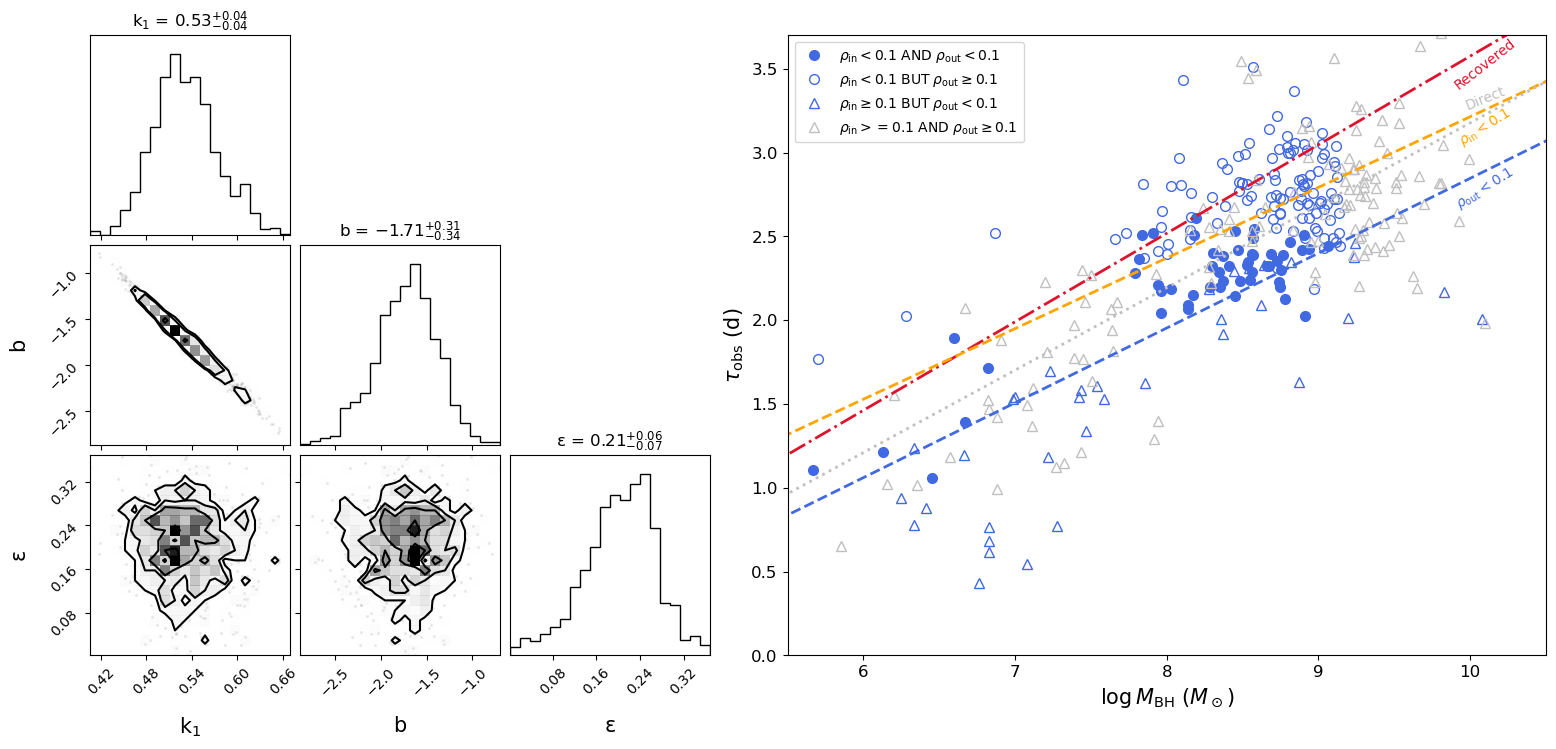

In [18]:
df = df_burke
mask_df = (df.Delta_AIC_low>1) & (df.Delta_AIC_hi>1) & (df.baseline/(df.ncadence-1) < 10**df.tau_mle) #& (10**df.tau_mle < 1e3*df.baseline) #& (df.SNR_mle>1)
df = df[mask_df]
Fitter = DependenceFitter1(df.tau_mle.to_numpy(), df.baseline.to_numpy(), df.ncadence.to_numpy(), df.log_M_BH.to_numpy(), df.log_M_BH_e.to_numpy(), redshift=df.z.to_numpy())
flat_samples = Fitter.fit()
fig_corner = corner.corner(
    flat_samples,show_titles=True,labels=[r"$\rm k_1$",r"$\rm b$",r"$\rm \epsilon$"],
    label_kwargs = dict(fontsize=15), title_kwargs=dict(fontsize=12)
);
gs = gridspec.GridSpec(ncols=2, nrows=1, figure=fig_corner)
ax = fig_corner.add_subplot(gs[:, -1])
box = ax.get_position()
box.x0 = box.x0 + 0.5
box.x1 = box.x1 + 1.1
ax.set_position(box)

baseline = df.baseline.to_numpy()
logMBH_array = df.log_M_BH.to_numpy()
logMBH_e_array = df.log_M_BH_e.to_numpy()
logLBH_array = df.log_L_bol.to_numpy() 
logLBH_e_array = df.log_L_bol_e.to_numpy() 
redshift_array = df.z.to_numpy()
logwave_array = df.wl_rest.to_numpy()
tau = df.tau_mle.to_numpy()

mask_good = 10**tau < 0.1*baseline
mask_int = 10**(0.5*logMBH_array-1.7) < 0.1*baseline
ax.plot(logMBH_array[(mask_int)&(mask_good)], (tau - np.log10(1+redshift_array))[(mask_int)&(mask_good)], 'o', ms=7,c='royalblue', label=r"$\rho_{\rm in}<0.1$ AND $\rho_{\rm out}<0.1$ ")
ax.plot(logMBH_array[(mask_int)&(~mask_good)], (tau - np.log10(1+redshift_array))[(mask_int)&(~mask_good)], 'o',ms=7, c='royalblue', markerfacecolor='none', label=r"$\rho_{\rm in}<0.1$ BUT $\rho_{\rm out}\geq 0.1$ ")
ax.plot(logMBH_array[(~mask_int)&(mask_good)], (tau - np.log10(1+redshift_array))[(~mask_int)&(mask_good)], '^', ms=7, c='royalblue', markerfacecolor='none', label=r"$\rho_{\rm in}\geq 0.1$ BUT $\rho_{\rm out}<0.1$ ")
ax.plot(logMBH_array[(~mask_int)&(~mask_good)], (tau - np.log10(1+redshift_array))[(~mask_int)&(~mask_good)], '^', ms=7, c='silver', markerfacecolor='none', label=r"$\rho_{\rm in}>=0.1$ AND $\rho_{\rm out}\geq 0.1$ ")

x_iter = np.arange(3,13)

ax.plot(x_iter, np.poly1d([np.median(flat_samples[:,0]), np.median(flat_samples[:,1])])(x_iter), lw=2,ls='-.',color="#DE142F")#,label="Recovered")
ax.text(10.1, np.poly1d([np.median(flat_samples[:,0]), np.median(flat_samples[:,1])])(10.1) - 0.1, "Recovered", rotation=38, ha='center', va='center', color="#DE142F")

ax.plot(x_iter, np.poly1d(np.polyfit(logMBH_array[mask_good], (tau - np.log10(1+redshift_array))[mask_good], deg=1))(x_iter), lw=2,ls='--', color='royalblue')#,label="Selected")
ax.text(10.1, np.poly1d(np.polyfit(logMBH_array[mask_good], (tau - np.log10(1+redshift_array))[mask_good], deg=1))(10.1) - 0.1, r"$\rho_{\rm out}< 0.1$ ", rotation=32, ha='center', va='center', color='royalblue')

ax.plot(x_iter, np.poly1d(np.polyfit(logMBH_array[mask_int], (tau - np.log10(1+redshift_array))[mask_int], deg=1))(x_iter), lw=2,ls='--', color='orange')#,label="Selected")
ax.text(10.1, np.poly1d(np.polyfit(logMBH_array[mask_int], (tau - np.log10(1+redshift_array))[mask_int], deg=1))(10.1) - 0.1, r"$\rho_{\rm in}< 0.1$ ", rotation=32, ha='center', va='center', color='orange')

ax.plot(x_iter, np.poly1d(np.polyfit(logMBH_array, (tau - np.log10(1+redshift_array)), deg=1))(x_iter), lw=2,ls=':', color='silver')#,label="Direct")
ax.text(10.1, np.poly1d(np.polyfit(logMBH_array, (tau - np.log10(1+redshift_array)), deg=1))(10.1) + 0.1, "Direct", rotation=22, ha='center', va='center', color='silver')

ax.set_xlabel(r"$\log M_{\rm BH}\ (M_\odot)$", fontsize=15)
ax.set_ylabel(r"$\tau_{\rm obs}\ (\rm d)$", fontsize=15)
ax.tick_params(axis='both', labelsize=12)
ax.set_xlim(5.5,10.5)
ax.set_ylim(0,3.7)
ax.legend()
fig_corner.savefig("figC.png")

In [19]:
from multiprocessing import Pool
from drw_toolkit import simu_fit_mle

np.random.seed(15)
repeat_times = 5
noise = 0.2

df = df_burke
z = np.repeat(df.z.to_numpy(),repeat_times)
t = np.repeat(df.x.to_numpy(),repeat_times)
yerr = np.repeat(df.yerr.to_numpy(),repeat_times)
sigma = np.repeat(df.sigma_mle.to_numpy(),repeat_times)

x = np.repeat(df.log_M_BH.to_numpy(),repeat_times)
xerr = np.repeat(df.log_M_BH_e.to_numpy(),repeat_times)             
tau_in = np.random.normal(0.5*np.random.normal(x, xerr) - 1.7, noise) + np.log10(1+z)

pool = Pool(8)
args = zip(t, tau_in, sigma, yerr)
log_pars = pool.starmap(simu_fit_mle, args)
pool.close()
pool.join()
pars0 = np.array(log_pars)
tau_out, sigma_out, Delta_AIC_low, Delta_AIC_hi, SNR= pars0.T
tau_out = np.reshape(tau_out, (-1, repeat_times))
sigma_out = np.reshape(sigma_out, (-1, repeat_times))
Delta_AIC_low = np.reshape(Delta_AIC_low, (-1, repeat_times))
Delta_AIC_hi = np.reshape(Delta_AIC_hi, (-1, repeat_times))
SNR = np.reshape(SNR, (-1, repeat_times))

In [20]:
np.random.seed(6)
df = df_burke
mask_df = (df.Delta_AIC_low>1) & (df.Delta_AIC_hi>1) & (df.baseline/(df.ncadence-1) < 10**df.tau_mle) #& (10**df.tau_mle < 1e3*df.baseline) #& (df.SNR_mle>1)
tau_out = tau_out[mask_df,:]
Delta_AIC_low = Delta_AIC_low[mask_df,:]
Delta_AIC_hi = Delta_AIC_hi[mask_df,:]
SNR = SNR[mask_df,:]

ncadence = df.ncadence.to_numpy()[mask_df]
baseline = df.baseline.to_numpy()[mask_df]
redshift_array = df.z.to_numpy()[mask_df]
mask_array = ((Delta_AIC_low.T>1) & (Delta_AIC_hi.T>1) & (baseline/(ncadence-1) < 10**tau_out.T)).T
choice = (np.sum(mask_array, axis=1) > 0)
x = df.log_M_BH.to_numpy()[mask_df][choice]
xerr = df.log_M_BH_e.to_numpy()[mask_df][choice]

In [ ]:
np.random.seed(9)
ind_array = np.array([np.random.choice(np.where(mask_array[choice][j,:])[0]) for j in range(sum(choice))])
tau_i = tau_out[choice][np.arange(sum(choice)), ind_array]
Fitter = DependenceFitter1(tau_i, baseline[choice], ncadence[choice], x, xerr, redshift=redshift_array[choice])
flat_samples = Fitter.fit()
fig_corner = corner.corner(
    flat_samples,show_titles=True,labels=[r"$\rm k_1$",r"$\rm b$",r"$\rm \epsilon$"],
    label_kwargs = dict(fontsize=15), title_kwargs=dict(fontsize=12)
);
gs = gridspec.GridSpec(ncols=2, nrows=1, figure=fig_corner)
ax = fig_corner.add_subplot(gs[:, -1])
box = ax.get_position()
box.x0 = box.x0 + 0.5
box.x1 = box.x1 + 1.1
ax.set_position(box)

tau = tau_i

mask_good = 10**tau < 0.1*baseline[choice]
mask_int = 10**(0.5*x-1.7) < 0.1*baseline[choice]
ax.plot(x[(mask_int)&(mask_good)], (tau - np.log10(1+redshift_array[choice]))[(mask_int)&(mask_good)], 'o', ms=7,c='royalblue', label=r"$\rho_{\rm in}<0.1$ AND $\rho_{\rm out}<0.1$ ")
ax.plot(x[(mask_int)&(~mask_good)], (tau - np.log10(1+redshift_array[choice]))[(mask_int)&(~mask_good)], 'o',ms=7, c='royalblue', markerfacecolor='none', label=r"$\rho_{\rm in}<0.1$ BUT $\rho_{\rm out}\geq 0.1$ ")
ax.plot(x[(~mask_int)&(mask_good)], (tau - np.log10(1+redshift_array[choice]))[(~mask_int)&(mask_good)], '^', ms=7, c='royalblue', markerfacecolor='none', label=r"$\rho_{\rm in}\geq 0.1$ BUT $\rho_{\rm out}<0.1$ ")
ax.plot(x[(~mask_int)&(~mask_good)], (tau - np.log10(1+redshift_array[choice]))[(~mask_int)&(~mask_good)], '^', ms=7, c='silver', markerfacecolor='none', label=r"$\rho_{\rm in}>=0.1$ AND $\rho_{\rm out}\geq 0.1$ ")

x_iter = np.arange(3,13)

ax.plot(x_iter, np.poly1d([np.median(flat_samples[:,0]), np.median(flat_samples[:,1])])(x_iter), lw=2,ls='-.',color='magenta')#,label="Recovered")
ax.text(10.1, np.poly1d([np.median(flat_samples[:,0]), np.median(flat_samples[:,1])])(10.1) - 0.1, "Recovered", rotation=38, ha='center', va='center', color='magenta')

ax.plot(x_iter, np.poly1d(np.polyfit(x[mask_good], (tau - np.log10(1+redshift_array[choice]))[mask_good], deg=1))(x_iter), lw=2,ls='--', color='royalblue')#,label="Selected")
ax.text(10.1, np.poly1d(np.polyfit(x[mask_good], (tau - np.log10(1+redshift_array[choice]))[mask_good], deg=1))(10.1) - 0.1, r"$\rho_{\rm out}< 0.1$ ", rotation=32, ha='center', va='center', color='royalblue')

ax.plot(x_iter, np.poly1d(np.polyfit(x[mask_int], (tau - np.log10(1+redshift_array[choice]))[mask_int], deg=1))(x_iter), lw=2,ls='--', color='royalblue')#,label="Selected")
ax.text(10.1, np.poly1d(np.polyfit(x[mask_int], (tau - np.log10(1+redshift_array[choice]))[mask_int], deg=1))(10.1) - 0.1, r"$\rho_{\rm in}< 0.1$ ", rotation=32, ha='center', va='center', color='royalblue')

ax.plot(x_iter, np.poly1d(np.polyfit(x, (tau - np.log10(1+redshift_array[choice])), deg=1))(x_iter), lw=2,ls=':', color='silver')#,label="Direct")
ax.text(10.1, np.poly1d(np.polyfit(x, (tau - np.log10(1+redshift_array[choice])), deg=1))(10.1) + 0.1, "Direct", rotation=22, ha='center', va='center', color='silver')

ax.set_xlabel(r"$\log M_{\rm BH}\ (M_\odot)$", fontsize=15)
ax.set_ylabel(r"$\tau_{\rm obs}\ (\rm d)$", fontsize=15)
ax.tick_params(axis='both', labelsize=12)
ax.set_xlim(5.5,10.5)
ax.set_ylim(0,3.7)
ax.legend()

 71%|███████████████████████████████████████████████████▎                    | 712/1000 [00:26<00:10, 26.93it/s]